# Análisis sobre el efecto de los tuits en el precio del Bitcoin.

### Voy a comparar el número de tuits que hablen negativamente sobre bitcoin, de cuyos datos dispongo en mi dataset, con el precio del bitcoin del día siguiente, que obtendré a través de la API de Coindesk.

### DATA ACQUISITION

In [175]:
# Importo pandas para trabajar con dataframes, numpy para posibles operaciones numéricas con los datos, y operator
# para encontrar valores en un diccionario.

import pandas as pd
import numpy as np
import operator

In [176]:
# Cargo y leo el dataset, convirtiéndolo en un DataFrame de pandas

dataset = pd.read_csv("Data_To_Hourervals_no_filter.csv", sep =';')

url_dataset = "https://www.kaggle.com/jaimebadiola/bitcoin-tweets-and-price/version/1"

In [177]:
dataset.head()

,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
0,01/08/2017 0:00,0.097156,1027.0,148.0,403.0,476.0,-0.504061,0.432704,2855.81,2863.06,2823.00,2825.92,184.02,"522951,00"
1,01/08/2017 1:00,0.064507,778.0,143.0,239.0,396.0,-0.381007,0.437953,2823.01,2860.02,2821.01,2853.38,77.3,219605.16
2,01/08/2017 2:00,0.119218,836.0,118.0,333.0,385.0,-0.394999,0.439269,2846.27,2858.04,2837.31,2841.60,135.83,386739.15
3,01/08/2017 3:00,0.004163,984.0,262.0,279.0,443.0,-0.431913,0.420278,2841.84,2863.88,2837.73,2862.93,143.2,408360.03
4,01/08/2017 4:00,0.065608,751.0,133.0,237.0,381.0,-0.405835,0.435645,2862.92,2876.00,2848.11,2874.99,222.53,637045.88


In [178]:
# Ahora obtengo los datos de la API.

import json
import requests

url = "https://api.coindesk.com/v1/bpi/historical/close.json?start=2017-01-08&end=2019-01-21"

response = requests.get(url)
results = response.json()
dataset2 = pd.DataFrame(results)

dataset2.head()

,bpi,disclaimer,time
2017-01-08,913.5238,This data was produced from the CoinDesk Bitco...,NaN
2017-01-09,899.3500,This data was produced from the CoinDesk Bitco...,NaN
2017-01-10,904.7925,This data was produced from the CoinDesk Bitco...,NaN
2017-01-11,775.9813,This data was produced from the CoinDesk Bitco...,NaN
2017-01-12,802.8288,This data was produced from the CoinDesk Bitco...,NaN


### WRANGLING

In [179]:
# Muestro los nombres de las columnas de mi dataset, para ver si me puedo deshacer de alguna que no 
# tenga relevancia para mi análisis.

print(dataset.columns.values)

['Date' 'Compound_Score' 'n' 'Count_Negatives' 'Count_Positives'
 'Count_Neutrals' 'Sent_Negatives' 'Sent_Positives' 'Open' 'High' 'Low'
 'Close' 'Volume (BTC)' 'Volume (Currency)']


In [180]:
# Me interesan Date, Count_Negatives, y la columna que tenga menos duplicados para guardarla hasta el 
# final. Miro a ver cuál es:

def less_duplicates(dataset):
    res = {}
    print("Dataset rows:", len(dataset.index))
    for col in dataset.columns:
        values = []
        for v in dataset["{}".format(col)]:
            values.append(v)
        res.update({col: len(set(values))})
    return max(res.items(), key=operator.itemgetter(1))[0]


print(less_duplicates(dataset))

Dataset rows: 12936
Date


In [181]:
# Me sirve Date. Por tanto, me deshago de todas las columnas que no necesito:

mis_columnas = ["Date", "Count_Negatives"]

for col in dataset.columns.values:
    if col not in mis_columnas:
        dataset = dataset.drop(col, axis = 1)

In [182]:
dataset.head()

,Date,Count_Negatives
0,01/08/2017 0:00,148.0
1,01/08/2017 1:00,143.0
2,01/08/2017 2:00,118.0
3,01/08/2017 3:00,262.0
4,01/08/2017 4:00,133.0


In [183]:
# Quiero los valores de los datos en datetime, para poder categorizarlos en franjas temporales:

dataset["Date"] = pd.to_datetime(dataset["Date"], dayfirst = True)

In [184]:
# Y ahora me quiero deshacer de las horas.

dataset["Date"] = dataset["Date"].dt.date

In [185]:
dataset.head()

,Date,Count_Negatives
0,2017-08-01,148.0
1,2017-08-01,143.0
2,2017-08-01,118.0
3,2017-08-01,262.0
4,2017-08-01,133.0


In [186]:
# Para unificar todos los registros de cada día, convierto mi columna Date en el índice

dataset = dataset.set_index("Date")

In [187]:
# Ahora agrupo por día:

dataset = dataset.groupby("Date").agg({"Count_Negatives": "sum"})

In [188]:
dataset.head()

,Count_Negatives
Date,
2017-08-01,7100.0
2017-08-02,4397.0
2017-08-03,4888.0
2017-08-04,4195.0
2017-08-05,2897.0


In [189]:
# Ya agrupados por días, vuelvo a sacar Date del index.

dataset = dataset.reset_index()

In [190]:
# Y reconvierto sus valores a datetime

dataset["Date"] = pd.to_datetime(dataset["Date"], dayfirst = True)
dataset.head()

,Date,Count_Negatives
0,2017-08-01,7100.0
1,2017-08-02,4397.0
2,2017-08-03,4888.0
3,2017-08-04,4195.0
4,2017-08-05,2897.0


In [191]:
# Ahora limpio el dataframe obtenido de la API

dataset2.head()

,bpi,disclaimer,time
2017-01-08,913.5238,This data was produced from the CoinDesk Bitco...,NaN
2017-01-09,899.3500,This data was produced from the CoinDesk Bitco...,NaN
2017-01-10,904.7925,This data was produced from the CoinDesk Bitco...,NaN
2017-01-11,775.9813,This data was produced from the CoinDesk Bitco...,NaN
2017-01-12,802.8288,This data was produced from the CoinDesk Bitco...,NaN


In [192]:
# Saco las fechas del index

dataset2 = dataset2.reset_index()
dataset2.head()

,index,bpi,disclaimer,time
0,2017-01-08,913.5238,This data was produced from the CoinDesk Bitco...,NaN
1,2017-01-09,899.3500,This data was produced from the CoinDesk Bitco...,NaN
2,2017-01-10,904.7925,This data was produced from the CoinDesk Bitco...,NaN
3,2017-01-11,775.9813,This data was produced from the CoinDesk Bitco...,NaN
4,2017-01-12,802.8288,This data was produced from the CoinDesk Bitco...,NaN


In [193]:
# Cambio el nombre de la columna de las fechas

dataset2 = dataset2.rename(columns={"index": "Date"})
dataset2.head()

,Date,bpi,disclaimer,time
0,2017-01-08,913.5238,This data was produced from the CoinDesk Bitco...,NaN
1,2017-01-09,899.3500,This data was produced from the CoinDesk Bitco...,NaN
2,2017-01-10,904.7925,This data was produced from the CoinDesk Bitco...,NaN
3,2017-01-11,775.9813,This data was produced from the CoinDesk Bitco...,NaN
4,2017-01-12,802.8288,This data was produced from the CoinDesk Bitco...,NaN


In [194]:
# Me deshago de las columnas innecesarias

dataset2 = dataset2.drop(["disclaimer", "time"], axis = 1)
display(dataset2.head())
len(dataset2.index)

,Date,bpi
0,2017-01-08,913.5238
1,2017-01-09,899.3500
2,2017-01-10,904.7925
3,2017-01-11,775.9813
4,2017-01-12,802.8288


746

In [195]:
display(dataset.head())
len(dataset.index)

,Date,Count_Negatives
0,2017-08-01,7100.0
1,2017-08-02,4397.0
2,2017-08-03,4888.0
3,2017-08-04,4195.0
4,2017-08-05,2897.0


539

Veo que por alguna razón, hay más valores en el dataframe que he optenido de la API, que en el mío original. Por tanto, no voy a poder concatenar directamente. Voy a tener que añadir valores del bpi a una nueva columna de mi dataframe original solo cuando dataset["Date"] y dataset2["Date"] sean iguales. Para eso, van a tener que estar todos los valores de ambas columnas en el mismo type.

In [196]:
# Para poder convertir las fechas de dataset2["Date"] a datetime, me tengo que deshacer primero de resgistros con 
# valores erróneos.

dataset2 = dataset2[(dataset2["Date"] != "updatedISO") & (dataset2["Date"] != "updated")]

In [197]:
# Convierto a datetime

dataset2["Date"] = pd.to_datetime(dataset2["Date"], dayfirst = True)

### ANALYSIS

In [198]:
# Ahora tengo que hacer binning. Voy a aplicarlo a mi columna Count_Negatives de mi dataframe original, dividiéndola en 
# Few, Medium, Many.

# Estudio los valores:

print("Minimum value:", dataset.Count_Negatives.min())
print("Maximum value:", dataset.Count_Negatives.max())
print("Average:", dataset.Count_Negatives.mean())
print("Meadian:", dataset.Count_Negatives.median())
print("Quantiles:", dataset.Count_Negatives.quantile([0.33, 0.66]))

Minimum value: 3.0
Maximum value: 32918.0
Average: 5882.769944341373
Meadian: 4931.0
Quantiles: 0.33    4176.54
0.66    6010.16
Name: Count_Negatives, dtype: float64


In [199]:
# Hago binning, llenando cada bin con el mismo número de valores. Los cortes serán los quantiles que he calculado 
# arriba.

Count_labels = ["Few", "Medium", "Many"]

bins = pd.qcut(dataset["Count_Negatives"], 3, labels = Count_labels)
dataset["Count_Negatives"] = bins

In [200]:
dataset.head()

,Date,Count_Negatives
0,2017-08-01,Many
1,2017-08-02,Medium
2,2017-08-03,Medium
3,2017-08-04,Medium
4,2017-08-05,Few


#### Voy a proceder a juntar los datos obtenidos a través de la API con mi dataset original. 

In [201]:
# Creo una nueva columna en mi dataframe original donde en BPI aparezcan los precios del bitcoin correspondientes a la
# fecha, obtenidos del dataframe que he conseguido a través de la API.

for i in dataset["Date"]:
    for e in dataset2["Date"]:
        if i == e:
            dataset["BPI"] = dataset2["bpi"]

In [202]:
dataset.head()

,Date,Count_Negatives,BPI
0,2017-08-01,Many,913.5238
1,2017-08-02,Medium,899.3500
2,2017-08-03,Medium,904.7925
3,2017-08-04,Medium,775.9813
4,2017-08-05,Few,802.8288


In [203]:
# Ya lo tengo. Pero lo que me interesa es ver si el número de tuits que hablan mal sobre el bitcoin tienen efecto 
# sobre el precio del bitcoin del día siguiente. Por tanto, tengo que añadir una columna que muestre el crecimiento 
# del precio del bitcoin de un día para otro

BPIs = []

for i in range(len(dataset["BPI"]) - 1):
    BPIs.append((dataset["BPI"][i+1] - dataset["BPI"][i])/dataset["BPI"][i])

BPIs.append(0)

In [204]:
print(len(BPIs))
print(len(dataset.index))

539
539


In [205]:
dataset["Price_Change"] = BPIs

In [206]:
dataset.head()

,Date,Count_Negatives,BPI,Price_Change
0,2017-08-01,Many,913.5238,-0.015516
1,2017-08-02,Medium,899.3500,0.006052
2,2017-08-03,Medium,904.7925,-0.142365
3,2017-08-04,Medium,775.9813,0.034598
4,2017-08-05,Few,802.8288,0.029013


In [207]:
# Ya no me sirven las columnas Date y BPIs

dataset = dataset.drop(["BPI", "Date"], axis =1)
dataset.head()

,Count_Negatives,Price_Change
0,Many,-0.015516
1,Medium,0.006052
2,Medium,-0.142365
3,Medium,0.034598
4,Few,0.029013


In [208]:
# Y ahora hago la media de los respectivos efectos de Few, Medium y Many

dataset = dataset.groupby("Count_Negatives").agg({"Price_Change": "mean"})

dataset

,Price_Change
Count_Negatives,
Few,0.003122
Medium,0.003426
Many,0.007934


In [209]:
dataset = dataset.reset_index()

In [210]:
dataset

,Count_Negatives,Price_Change
0,Few,0.003122
1,Medium,0.003426
2,Many,0.007934


### REPORTING

In [211]:
# Importo matplotlib para visualizar gráficos

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Effect of negative tweets on Bitcoin price\n')

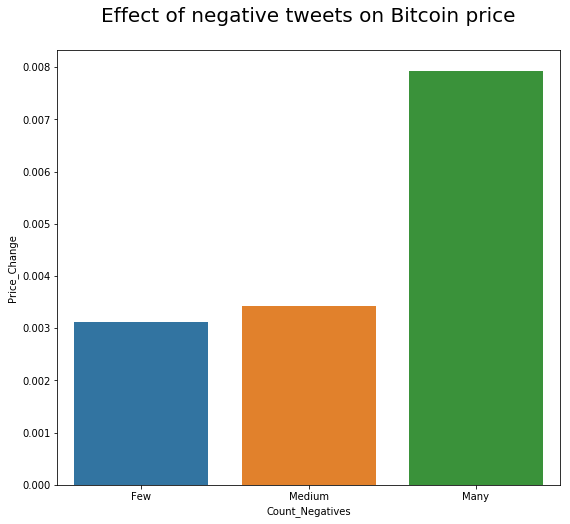

In [212]:
# dataset.plot.bar()

title = "Effect of negative tweets on Bitcoin price"

fig, ax = plt.subplots(figsize = (9,8))
barchart = sns.barplot(data = dataset, x = "Count_Negatives", y = "Price_Change")
plt.title(title + "\n", fontsize = 20)

In [213]:
fig = barchart.get_figure()
fig.savefig(title + '.png')

Los resultados muestran que cuando el número de tuits con carga negativa se encuentra en mayor rango, el precio del bitcoin del día posterior tiene de media un mayor crecimiento.

Esto puede deberse a:

#### - "Cualquier publicidad es buena publicidad". 

Cuanto más se hable de algo, bien o mal, más presente estará entre la sociedad, y más importancia cobrará. Twitter no es precisamente una plataforma seria a donde acudan inversores a buscar tendencias bursátiles entre las opiniones de los tuiteros. Por lo tanto, más que la calidad del contenido, es la cantidad del contenido de Twitter la que parece reflejar el acrecimiento difusivo de la criptomoneda, lo cual sí que tiene un golpe de efecto sobre el valor de la misma. (Podría calcular ahora si el gráfico es parecido cuando en lugar de "tuits negativos", mido el efecto de "tuits totales que hablen sobre bitcoin").

#### -  Críticas al crecimiento de la burbuja.
Durante el exponencial crecimiento del bitcoin a finales de 2017, se escuchaban muchos comentarios que auguraban la explosión de la burbuja. Por tanto, a medida que su valor crecía, más en picado parecía que iba a ser la caída, y más "morbo" tenía comentarlo.

#### - No existe tal relación
Puede ser que, en contraste, el número de tuits negativos no tenga ningún efecto sobre el precio del bitcoin del día siguiente. Es posible que el efecto de causalidad sea inverso: el número de tuits negativos sobre el bitcoin es una consecuencia del crecimiento de su precio, y no al revés. Además, tanto el mundo de las inversiones (sobre todo en un sector digital), como la actividad en Twitter tiene un movimiento constante, y a lo largo del día puede variar todo en gran medida. 

En consecuencia, sería interesante continuar este análisis estudiando el efecto de los "tuits totales que hablen sobre bitcoin", comprobando si hay algún tipo de relación cuando se mide el efecto con causalidad inversa, y categorizando los registros en franjas temporales menores (2h en lugar de 24h).